# **Music Listening and Music Making During the Coronavirus: Factor Analysis**


In [165]:
import numpy as np, pandas as pd, seaborn as sns, os, sys, itertools, re, warnings, math, scipy as sp, sklearn, matplotlib.pyplot as plt, matplotlib.cm as cm, statsmodels.stats.api as sms, statsmodels.api as sm
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn import preprocessing, metrics, manifold
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from IPython.display import Image, HTML
from matplotlib.ticker import NullFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)
warnings.filterwarnings(action='ignore')
LW = 0
if LW:
    os.chdir("/Users/home/Desktop/Research/Coronavirus/Public GitHub")
%run Coronavirus_Music_Functions.ipynb

In [166]:
if LW: 
    with open("/Users/home/Desktop/Research/Coronavirus/Public GitHub/cleaned_data.csv", 
          encoding="utf8", errors='ignore') as file:
        data = pd.read_csv(file)
else:
    data = pd.read_csv('cleaned_data.csv')    
original_df = data.rename(columns={"Country_Country Name": "Country"})
original_df.shape

(5113, 234)

In [138]:
original_df['Survey Info_Group'].value_counts()

both               3003
listening only     1669
neither             414
performing only      27
Name: Survey Info_Group, dtype: int64

### **Preprocessing**

In [139]:
# find columns with 20% or more missing data
missing = pd.DataFrame(original_df.isnull().sum()/original_df.shape[0])*100
missing = missing[missing[0] >= 20]
missing = missing.sort_values(by=[0], ascending=False)

cols = [i for i in missing.index if not i.startswith('Making Music') 
        and not i.startswith('Music Listening') 
        and not i.startswith('Activities') ]
missing.loc[cols,:]

,0
Demographics_Health_Bored,47.897516


In [140]:
# delete column with more than 20% missing data and other columns we don't need
# NOTE: added gender to this list because we now have new binary gender column
delete_cols = ['Demographics_Health_Bored', 
               'Demographics_Health_COVID Contact Binary', 'Demographics_COVID_Work Changed Binary', # recoding of other variables
               'Country_Confirmed Cases', 'Country_Confirmed Deaths', 'Country_Containment Health Index',
               'Country_Economic Support Index','Country_Government Response Index', 'Country_Stringency Index',
               'ESM_ID','date', 'Demographics_General_Gender'] + [col for col in original_df.columns if '-No Response' in col or '-Prefer Not To Say' in col]
data = original_df.drop(columns = delete_cols, axis = 1).reset_index(drop=True)
data.shape

# LF renaming gender col in original df so we don't break any code downstream
original_df.rename(columns={'Demographics_General_Gender_binary': 'Demographics_General_Gender'}, inplace=True, errors="raise")                                 

In [141]:
# get list of demographic columns
demographics = ['ID','Country'] + [col for col in data.columns if col.startswith('Demographics_')]
dem = data[demographics]
dem.columns = dem.columns.str.lstrip('Demographics_')

In [142]:
# look at missing data for demographic columns
missing = pd.DataFrame(dem.isnull().sum()/dem.shape[0])*100
missing = missing[missing[0] > 0]
missing = missing.sort_values(by=[0], ascending=False)
missing.head(10)

,0
Health_Lonely,4.107178
Health_Arousal,4.068062
Health_Depressed,4.068062
Health_Anxious,4.009388
Health_Negative Valence,3.950714
Health_Stressed,3.852924
Health_Positive Valence,3.539996
Personality_Openness,3.363974
Personality_Agreeableness,3.363974
Personality_Conscientiousness,3.363974


In [143]:
# imputing missing variables
continuous = []
for column in missing.index:
    if len(dem[column].unique()) > 3:
        continuous.append(column)

binary = [col for col in missing.index if col not in continuous]

In [144]:
# binary imputation -- median
for column in binary:
    dem[column] = dem.groupby(["Country"], sort = False)[column].apply(lambda x: x.fillna(x.median()))

In [145]:
# # examine distributions of continuous columns
# plt.figure(figsize=(20,20))
# for i, column in enumerate(continuous):
#     plt.subplot(5, 4, i+1)
#     sns.distplot(dem[column], hist = False, norm_hist = True, kde_kws={"bw":1})
#     plt.title(column.split('_')[1], size = 22)
#     plt.ylabel('KDE estimates', fontsize=16)
#     plt.xlabel('')
#     plt.tight_layout()
#     plt.tick_params(axis='both', which='major', labelsize=12)
# plt.show()
# NOTE from LF: might want to recode num times leave into just one 10+ category to make it more normal?

In [146]:
# continuous imputation: impute  values based on the median for the participant's current country
for i, column in enumerate(continuous):
    dem[column] = dem.groupby(["Country"], sort = False)[column].apply(lambda x: x.fillna(x.median()))
    
dem.reset_index(inplace = True, drop = True) 

In [147]:
# correlations
cor_real = dem.corr()
cor_abs = dem.corr().abs()
triangle = cor_real.where(np.triu(np.ones(cor_real.shape), k = 1).astype(np.bool))

cor = cor_abs.unstack()
cor = cor.sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['cor']
cor = cor.query('cor < 1')

cor_high = cor.query('0.90 < cor < 1')
print((len(cor_high)/len(cor))*100, "% of correlations > 0.90 in the demographic data.")
print("Highest (absolute value) correlation is", cor['cor'].max())

# sns.heatmap(cor_real)

0.0 % of correlations > 0.90 in the demographic data.
Highest (absolute value) correlation is 0.6966676876563982


In [148]:
# getting continuous/binary columns for scaling
continuous = []
for column in dem.columns:
    if len(dem[column].unique()) > 3:
        continuous.append(column)

binary = [col for col in dem.columns if col not in continuous]

In [149]:
# we only want to scale the continuous data (not binary or ID)
col_names = [c for c in continuous if c not in ['ID']]
to_scale = dem[col_names]

# scale data by country
for column in [c for c in col_names if c is not 'Country']:
    to_scale[column] = to_scale.groupby(["Country"], sort = False)[column].transform(lambda x: minmax_scale(x.astype(float)))
scaled = pd.DataFrame(to_scale, columns = col_names)
# scaled.describe().round(3).T

In [150]:
# make dataframe with the binary columns
binary_data = dem[binary]
# binary_data.describe().round(3).T

In [151]:
# fully-preprocessed data
all_scaled = pd.concat([scaled, binary_data], axis=1)
all_scaled = all_scaled.drop(columns=['Country'])

### **Factor Analysis: Health/Emotional/Personality Characteristics**

In [152]:
# columns to use in factor analysis: all person-level demographic variables EXCEPT music responses, no country variables (oxford data, etc.)
col_list = all_scaled.columns.tolist()
col_list = [c for c in col_list if 'Music_' not in c]
col_list.sort()

all_psych = all_scaled[col_list]
all_psych.columns = all_psych.columns.str.replace(r'^.*_', '', regex=True)
all_psych.columns = all_psych.columns.str.replace(r'^.*-', '', regex=True)
all_psych.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Current Place Home,5113.0,1.0,0.2,0.0,1.0,1.0,1.0,1.0
Alone,5113.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
Child,5113.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0
Elderly,5113.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0
Friend,5113.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0
Other,5113.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0
Parent,5113.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
Partner,5113.0,0.6,0.5,0.0,0.0,1.0,1.0,1.0
Pet,5113.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
Shared,5113.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0


51 number of columns
Bartlett’s test of sphericity: 68781.78522248396 0.0
Kaiser-Meyer-Olkin test: 0.5392337263719881


([<matplotlib.axis.XTick at 0x12a67d710>,
 <a list of 11 Text major ticklabel objects>)

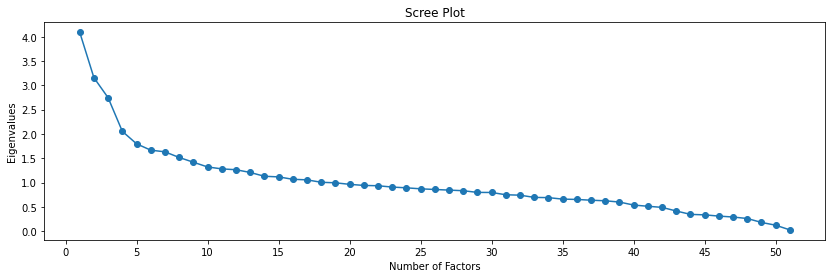

In [153]:
# assessing how well the factor analysis explains the variables above
chi_square_value, p_value = calculate_bartlett_sphericity(all_psych)
kmo_all, kmo_model = calculate_kmo(all_psych)

print(len(all_psych.columns), "number of columns")
print("Bartlett’s test of sphericity:", chi_square_value, p_value)
print("Kaiser-Meyer-Olkin test:", kmo_model)

fa = FactorAnalyzer()
fa.fit(all_psych, len(all_psych.columns))
eigenvalues, vectors = fa.get_eigenvalues()

plt.plot(range(1, all_psych.shape[1]+1), eigenvalues)
plt.scatter(range(1, all_psych.shape[1]+1), eigenvalues)
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalues')
plt.title("Scree Plot")
plt.xticks(np.arange(0, 55, 5)) 

### Rotation

In [154]:
# 4 factors
num_factors = 4
factor_names = ['F1', 'F2', 'F3', 'F4']

quartimax = FactorAnalyzer(num_factors, rotation = 'quartimax')
all_quartimax = quartimax.fit_transform(all_psych)
quartimax_loadings = quartimax.loadings_
quartimax_communalities = quartimax.get_communalities()
quartimax_variance = quartimax.get_factor_variance()

quartimax_loading_DF = pd.DataFrame(columns = ['Demographic Feature'] + factor_names)
quartimax_loading_DF['Demographic Feature'] = all_psych.columns
for i, c in enumerate(all_psych.columns):
    quartimax_loading_DF.iloc[i, 1:] = quartimax_loadings[i]

quartimax_variance_DF = pd.DataFrame(columns = ['Variance'] + factor_names)
quartimax_variance_DF['Variance'] = ['SS Loadings', 'Variance Explained', 'Cumulative Variance']
for i, c in enumerate(quartimax_variance_DF.index):
    quartimax_variance_DF.iloc[i, 1:] = quartimax_variance[i]
    
# find top features
test = quartimax_loading_DF.set_index(['Demographic Feature'])
test = test.apply(pd.to_numeric, errors='coerce')
test = test.abs()
variance_new = quartimax_variance_DF.loc[1:,:].set_index(['Variance']).T

variance_new['Top Features'] = ""
variance_new['Top Features'] = variance_new['Top Features'].astype('object')

for c in variance_new.index.tolist():
    max_vals = test[c].nlargest(3).index.tolist()
    variance_new.at[c, 'Top Features'] = max_vals
    
variance_new

Variance,Variance Explained,Cumulative Variance,Top Features
F1,0.0665733,0.0665733,"[Depressed, Stressed, Anxious]"
F2,0.0416246,0.108198,"[Positive Valence, Arousal, General Health]"
F3,0.0408254,0.149023,"[Age, Retired, Parent]"
F4,0.0356707,0.184694,"[Partner, Alone, Child]"


In [155]:
# 5 factors
num_factors = 5
factor_names = ['F1', 'F2', 'F3', 'F4', 'F5']

quartimax = FactorAnalyzer(num_factors, rotation = 'quartimax')
all_quartimax = quartimax.fit_transform(all_psych)
quartimax_loadings = quartimax.loadings_
quartimax_communalities = quartimax.get_communalities()
quartimax_variance = quartimax.get_factor_variance()

quartimax_loading_DF = pd.DataFrame(columns = ['Demographic Feature'] + factor_names)
quartimax_loading_DF['Demographic Feature'] = all_psych.columns
for i, c in enumerate(all_psych.columns):
    quartimax_loading_DF.iloc[i, 1:] = quartimax_loadings[i]

quartimax_variance_DF = pd.DataFrame(columns = ['Variance'] + factor_names)
quartimax_variance_DF['Variance'] = ['SS Loadings', 'Variance Explained', 'Cumulative Variance']
for i, c in enumerate(quartimax_variance_DF.index):
    quartimax_variance_DF.iloc[i, 1:] = quartimax_variance[i]
    
# find top features
test = quartimax_loading_DF.set_index(['Demographic Feature'])
test = test.apply(pd.to_numeric, errors='coerce')
test = test.abs()
variance_new = quartimax_variance_DF.loc[1:,:].set_index(['Variance']).T

variance_new['Top Features'] = ""
variance_new['Top Features'] = variance_new['Top Features'].astype('object')

for c in variance_new.index.tolist():
    max_vals = test[c].nlargest(3).index.tolist()
    variance_new.at[c, 'Top Features'] = max_vals
    
variance_new

Variance,Variance Explained,Cumulative Variance,Top Features
F1,0.0665486,0.0665486,"[Depressed, Stressed, Anxious]"
F2,0.0408525,0.107401,"[Age, Retired, Parent]"
F3,0.0405224,0.147923,"[Positive Valence, Arousal, General Health]"
F4,0.0355651,0.183489,"[Partner, Alone, Child]"
F5,0.0268418,0.21033,"[Suburban, Urban, Rural]"


In [156]:
# 6 factors
num_factors = 6
factor_names = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']

quartimax = FactorAnalyzer(num_factors, rotation = 'quartimax')
all_quartimax = quartimax.fit_transform(all_psych)
quartimax_loadings = quartimax.loadings_
quartimax_communalities = quartimax.get_communalities()
quartimax_variance = quartimax.get_factor_variance()

quartimax_loading_DF = pd.DataFrame(columns = ['Demographic Feature'] + factor_names)
quartimax_loading_DF['Demographic Feature'] = all_psych.columns
for i, c in enumerate(all_psych.columns):
    quartimax_loading_DF.iloc[i, 1:] = quartimax_loadings[i]

quartimax_variance_DF = pd.DataFrame(columns = ['Variance'] + factor_names)
quartimax_variance_DF['Variance'] = ['SS Loadings', 'Variance Explained', 'Cumulative Variance']
for i, c in enumerate(quartimax_variance_DF.index):
    quartimax_variance_DF.iloc[i, 1:] = quartimax_variance[i]
    
# find top features
test = quartimax_loading_DF.set_index(['Demographic Feature'])
test = test.apply(pd.to_numeric, errors='coerce')
test = test.abs()
variance_new = quartimax_variance_DF.loc[1:,:].set_index(['Variance']).T

variance_new['Top Features'] = ""
variance_new['Top Features'] = variance_new['Top Features'].astype('object')

for c in variance_new.index.tolist():
    max_vals = test[c].nlargest(3).index.tolist()
    variance_new.at[c, 'Top Features'] = max_vals
    
variance_new

Variance,Variance Explained,Cumulative Variance,Top Features
F1,0.0662254,0.0662254,"[Depressed, Stressed, Anxious]"
F2,0.0408541,0.107079,"[Age, Retired, Parent]"
F3,0.03635,0.143429,"[Positive Valence, Arousal, General Health]"
F4,0.0346758,0.178105,"[Partner, Alone, Child]"
F5,0.0310782,0.209183,"[Employed Full Time, Retired, Now Work From Home]"
F6,0.0268396,0.236023,"[Suburban, Urban, Rural]"


In [157]:
# 7 factors
num_factors = 7
factor_names = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']

quartimax = FactorAnalyzer(num_factors, rotation = 'quartimax')
all_quartimax = quartimax.fit_transform(all_psych)
quartimax_loadings = quartimax.loadings_
quartimax_communalities = quartimax.get_communalities()
quartimax_variance = quartimax.get_factor_variance()

quartimax_loading_DF = pd.DataFrame(columns = ['Demographic Feature'] + factor_names)
quartimax_loading_DF['Demographic Feature'] = all_psych.columns
for i, c in enumerate(all_psych.columns):
    quartimax_loading_DF.iloc[i, 1:] = quartimax_loadings[i]

quartimax_variance_DF = pd.DataFrame(columns = ['Variance'] + factor_names)
quartimax_variance_DF['Variance'] = ['SS Loadings', 'Variance Explained', 'Cumulative Variance']
for i, c in enumerate(quartimax_variance_DF.index):
    quartimax_variance_DF.iloc[i, 1:] = quartimax_variance[i]
    
# find top features
test = quartimax_loading_DF.set_index(['Demographic Feature'])
test = test.apply(pd.to_numeric, errors='coerce')
test = test.abs()
variance_new = quartimax_variance_DF.loc[1:,:].set_index(['Variance']).T

variance_new['Top Features'] = ""
variance_new['Top Features'] = variance_new['Top Features'].astype('object')

for c in variance_new.index.tolist():
    max_vals = test[c].nlargest(3).index.tolist()
    variance_new.at[c, 'Top Features'] = max_vals
    
variance_new

Variance,Variance Explained,Cumulative Variance,Top Features
F1,0.066109,0.066109,"[Depressed, Stressed, Anxious]"
F2,0.0406285,0.106738,"[Age, Retired, Parent]"
F3,0.0354947,0.142232,"[Positive Valence, Arousal, General Health]"
F4,0.0339758,0.176208,"[Partner, Alone, Child]"
F5,0.0322374,0.208445,"[Employed Full Time, Retired, Now Work From Home]"
F6,0.0287528,0.237198,"[Suburban, Urban, Rural]"
F7,0.0281667,0.265365,"[Urban, Rural, None]"


### Select 5 factor solution (for now)

In [158]:
# 5 factors
num_factors = 5
factor_names = ['F1', 'F2', 'F3', 'F4', 'F5']

quartimax = FactorAnalyzer(num_factors, rotation = 'quartimax')
all_quartimax = quartimax.fit_transform(all_psych)
quartimax_loadings = quartimax.loadings_
quartimax_communalities = quartimax.get_communalities()
quartimax_variance = quartimax.get_factor_variance()

quartimax_loading_DF = pd.DataFrame(columns = ['Demographic Feature'] + factor_names)
quartimax_loading_DF['Demographic Feature'] = all_psych.columns
for i, c in enumerate(all_psych.columns):
    quartimax_loading_DF.iloc[i, 1:] = quartimax_loadings[i]

quartimax_variance_DF = pd.DataFrame(columns = ['Variance'] + factor_names)
quartimax_variance_DF['Variance'] = ['SS Loadings', 'Variance Explained', 'Cumulative Variance']
for i, c in enumerate(quartimax_variance_DF.index):
    quartimax_variance_DF.iloc[i, 1:] = quartimax_variance[i]
    
# find top features
test = quartimax_loading_DF.set_index(['Demographic Feature'])
test = test.apply(pd.to_numeric, errors='coerce')
test = test.abs()
variance_new = quartimax_variance_DF.loc[1:,:].set_index(['Variance']).T

variance_new['Top Features'] = ""
variance_new['Top Features'] = variance_new['Top Features'].astype('object')

for c in variance_new.index.tolist():
    max_vals = test[c].nlargest(3).index.tolist()
    variance_new.at[c, 'Top Features'] = max_vals
    
quartimax_variance_DF

,Variance,F1,F2,F3,F4,F5
0,SS Loadings,3.39398,2.08348,2.06664,1.81382,1.36893
1,Variance Explained,0.0665486,0.0408525,0.0405224,0.0355651,0.0268418
2,Cumulative Variance,0.0665486,0.107401,0.147923,0.183489,0.21033


In [159]:
quartimax_loading_DF

,Demographic Feature,F1,F2,F3,F4,F5
0,Current Place Home,-0.00466537,-0.12657,0.0522872,0.121263,-0.00550492
1,Alone,0.0273075,-0.0370394,0.0390536,-0.574169,0.0355784
2,Child,0.0717959,0.100806,0.154134,0.541609,-0.0192776
3,Elderly,-0.0162719,0.0801566,0.0150317,-0.0631265,-0.018181
4,Friend,0.0639855,0.107099,0.0359953,-0.0561304,-0.0125776
5,Other,-0.00789257,-0.0703437,-0.0725558,-0.0278015,-0.0254248
6,Parent,0.0176797,0.462751,0.00290908,-0.321376,0.00143794
7,Partner,-0.0248976,-0.23041,0.0519645,0.708111,-0.0210686
8,Pet,0.0012443,0.0235217,-0.0541051,0.181514,0.00448314
9,Shared,0.0555875,0.0990168,-0.0282394,-0.0664928,-0.0201062


**Factor interpretations:**
- Factor 1: Negative Emotions [Stressed, Depressed, Anxious]
- Factor 2: Living Situation [Partner, Alone, Child]
- Factor 3: Positive Emotions [Positive Valence, Arousal, General Health]
- Factor 4: Age [Age, Retired, Parent]
- Factor 5: City Type [Suburban, Urban, Rural]

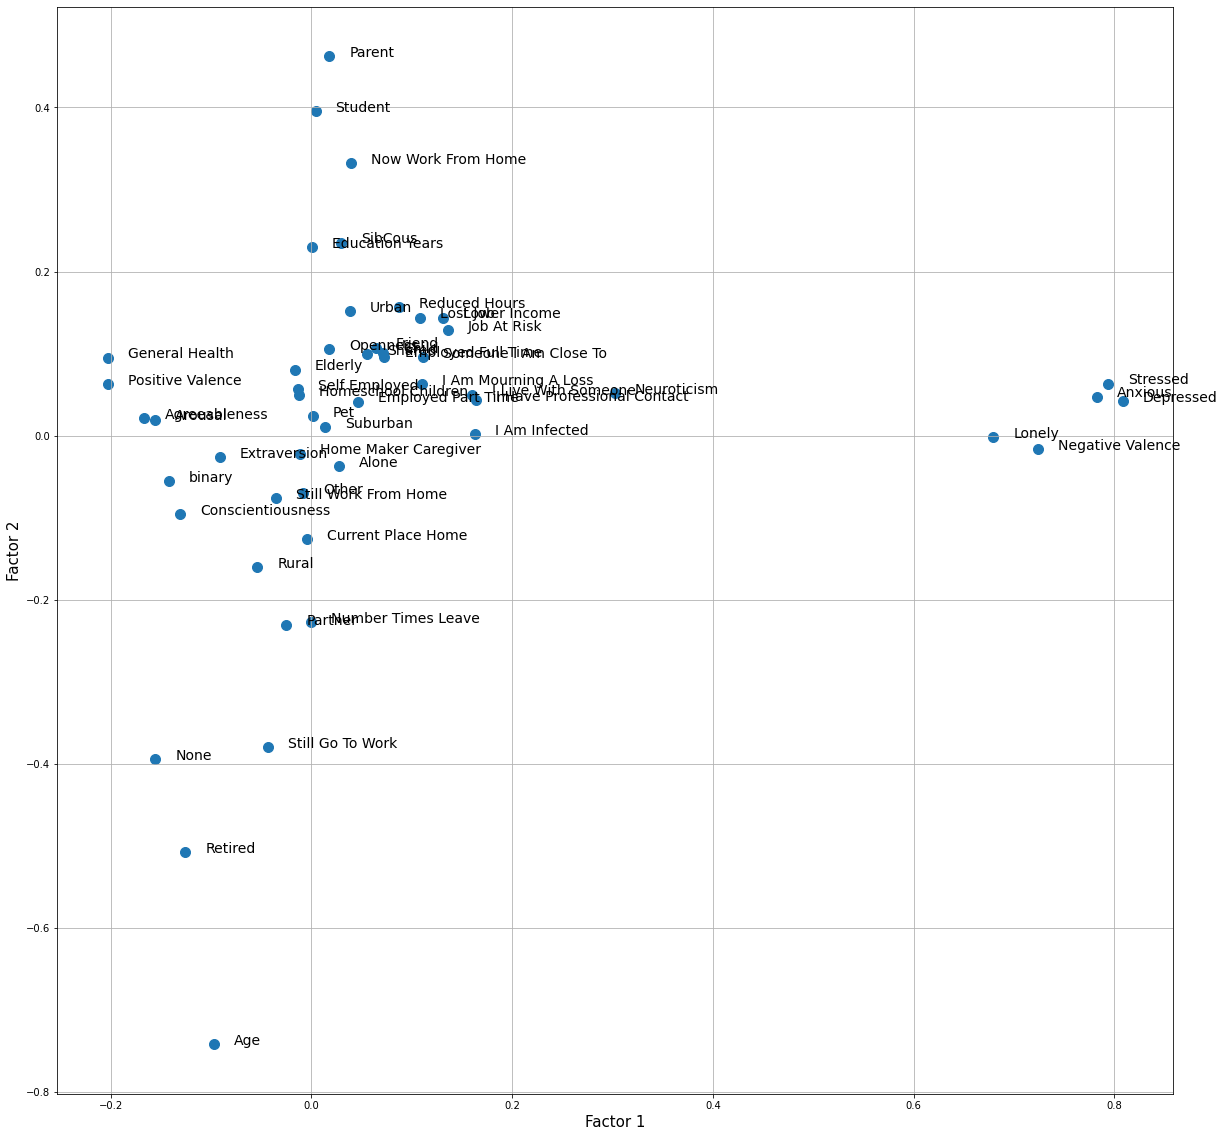

In [160]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Factor 1', fontsize = 15)
ax.set_ylabel('Factor 2', fontsize = 15)

ax.scatter(quartimax_loading_DF.loc[:, 'F1'], quartimax_loading_DF.loc[:, 'F2'], s = 100)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=14)

label_point(quartimax_loading_DF.F1, quartimax_loading_DF.F2, 
            quartimax_loading_DF['Demographic Feature'], plt.gca())  

ax.grid()
plt.show()

### Summarize how each participant scores on the 5 Factors and make new dataframe

In [161]:
# df of the factor scores for each person
factor_list = ['F1', 'F2', 'F3', 'F4', 'F5']
fa_components_DF = pd.DataFrame(data = all_quartimax, columns = factor_list)
fa_components_DF.head(3)

,F1,F2,F3,F4,F5
0,-0.325420,-0.158048,0.320504,0.430229,1.511740
1,-0.572796,-0.750935,-0.456592,0.347288,-0.271240
2,0.009270,-0.912322,-0.378811,0.349901,1.483753


In [162]:
# merge with ID
all_FA = pd.concat([fa_components_DF, dem[['ID']]], axis = 1)
all_FA = all_FA.iloc[:, np.r_[5, 0:5]]
all_FA.head(3)

,ID,F1,F2,F3,F4,F5
0,2,-0.325420,-0.158048,0.320504,0.430229,1.511740
1,3,-0.572796,-0.750935,-0.456592,0.347288,-0.271240
2,4,0.009270,-0.912322,-0.378811,0.349901,1.483753


In [163]:
# merge with all other columns
factors_all_data = all_FA.merge(original_df, on='ID', how='outer', suffixes=('', ''))
print(factors_all_data.shape)
factors_all_data.head(3)

(5113, 239)


,ID,F1,F2,F3,F4,F5,Activities_Call People,Activities_Cleaning,Activities_Cooking,Activities_Crafting,Activities_Create Online Content,Activities_Drugs or Alcohol,Activities_Exercise Indoors,Activities_Exercise Outdoors,Activities_Fashion,Activities_Gardening,Activities_Learning New Skills,Activities_Making Music,Activities_Meditating,Activities_Music Listening,Activities_Online Dating,Activities_Photography,Activities_Playing Games,Activities_Reading Books,Activities_Searching for Music Info,Activities_Sexual Activity,Activities_Shopping Online,Activities_Social Media,Activities_Thinking About Music,Activities_Virtual Exhibitions,Activities_Visit People in Person,Activities_Volunteering,Activities_Watching Movies,Activities_Watching News,Activities_Writing,Country_Confirmed Cases,Country_Confirmed Deaths,Country_Containment Health Index,Country,Country_Economic Support Index,Country_Government Response Index,Country_Stringency Index,Demographics_COVID_Current Place Home,Demographics_COVID_Living Situation-Alone,Demographics_COVID_Living Situation-Child,Demographics_COVID_Living Situation-Elderly,Demographics_COVID_Living Situation-Friend,Demographics_COVID_Living Situation-No Response,Demographics_COVID_Living Situation-Other,Demographics_COVID_Living Situation-Parent,Demographics_COVID_Living Situation-Partner,Demographics_COVID_Living Situation-Pet,Demographics_COVID_Living Situation-Shared,Demographics_COVID_Living Situation-SibCous,Demographics_COVID_Number Times Leave,Demographics_COVID_Ways Work Affected-Homeschool Children,Demographics_COVID_Ways Work Affected-Job At Risk,Demographics_COVID_Ways Work Affected-Lost Job,Demographics_COVID_Ways Work Affected-Lower Income,Demographics_COVID_Ways Work Affected-No Response,Demographics_COVID_Ways Work Affected-Now Work From Home,Demographics_COVID_Ways Work Affected-Reduced Hours,Demographics_COVID_Ways Work Affected-Still Go To Work,Demographics_COVID_Ways Work Affected-Still Work From Home,Demographics_COVID_Work Changed Binary,Demographics_General_Age,Demographics_General_City Type-No Response,Demographics_General_City Type-Rural,Demographics_General_City Type-Suburban,Demographics_General_City Type-Urban,Demographics_General_Education Years,Demographics_General_Employement Before COVID-Employed Full Time,Demographics_General_Employement Before COVID-Employed Part Time,Demographics_General_Employement Before COVID-Home Maker Caregiver,Demographics_General_Employement Before COVID-No Response,Demographics_General_Employement Before COVID-Prefer Not To Say,Demographics_General_Employement Before COVID-Retired,Demographics_General_Employement Before COVID-Self Employed,Demographics_General_Employement Before COVID-Student,Demographics_General_Gender,Demographics_Health_Anxious,Demographics_Health_Arousal,Demographics_Health_Bored,Demographics_Health_COVID Contact Binary,Demographics_Health_Depressed,Demographics_Health_General Health,Demographics_Health_Infected with COVID-I Am Infected,Demographics_Health_Infected with COVID-I Am Mourning A Loss,Demographics_Health_Infected with COVID-I Have Professional Contact,Demographics_Health_Infected with COVID-I Live With Someone,Demographics_Health_Infected with COVID-No Response,Demographics_Health_Infected with COVID-None,Demographics_Health_Infected with COVID-Prefer Not To Say,Demographics_Health_Infected with COVID-Someone I Am Close To,Demographics_Health_Lonely,Demographics_Health_Negative Valence,Demographics_Health_Positive Valence,Demographics_Health_Stressed,Demographics_Music_Making Music-Alone,Demographics_Music_Making Music-Both Alone And Together,Demographics_Music_Making Music-No Response,Demographics_Music_Making Music-Together,Demographics_Music_Music Importance,Demographics_Music_Number of Concerts,Demographics_Music_Ollen,Demographics_Personality_Agreeableness,Demographics_Personality_Conscientiousness,Demographics_Personality_Extraversion,Demographics_Personality_Neuroticism,Demographics_Personality_Openness,ESM

In [164]:
factors_all_data.to_csv(r'factors_all_data.csv', index = None, header = True)